In [ ]:
!pip install optuna
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split, SubsetRandomSampler
from torchvision import transforms
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import optuna

In [48]:
def oneTwo(trial):
    # We want to optimize the number of layers, hidden untis.
    n_layers = trial.suggest_int("n_layers", 1, 2)
    layers = []
    in_features = 1
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 16, 120,8)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_uniform("dropout_l{}".format(i), 0, 0.3)
        layers.append(nn.Dropout(p))
        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    return nn.Sequential(*layers)


## Plot function

In [49]:
def Plot(yTrain,yTest,width=18,height=8):
    fig, axs = plt.subplots(1,2)
    # fig.suptitle('Vertically stacked subplots')
    fig.set_figwidth(width)
    fig.set_figheight(height)
    axs[0].scatter(train_df.input, yTrain, label='Predicted points', color = 'r')
    axs[0].scatter(train_df.input, train_df.label, label='Training points', color = 'g')
    axs[0].legend()
    axs[0].set(xlabel='x-train', ylabel='y-train')
    axs[1].scatter(x_test.detach().numpy(), yTest, label='Predicted points', color = 'r')
    axs[1].scatter(test_df.input, test_df.label, label='Test points')
    axs[1].legend()
    axs[1].set(xlabel='x-test', ylabel='y-test')

## NN with 2 hidden layer

In [51]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No,activation,p=0,initialization=False):
        """
        Ni - Input size
        Nh - Neurons in the hidden layer
        No - Output size
        """
        super().__init__()

        # print('Network initialized')
        self.fc1 = nn.Linear(in_features = Ni, out_features = Nh1)
        self.fc2 = nn.Linear(in_features = Nh1, out_features = Nh2)
        self.out = nn.Linear(in_features = Nh2, out_features = No)
        self.act = activation
        self.dropout = nn.Dropout(p)
        
        # Initialization
        if initialization:
            self.initialize_weights()
            
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Linear):
                # nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.xavier_normal_(m.weight)

## NN with one hidden layer

In [52]:
class Net_one_layer(nn.Module):
    
    def __init__(self, Ni, Nh, No,activation,p =0):
        """
        Ni - Input size
        Nh - Neurons in the hidden layer
        No - Output size
        """
        super().__init__()
        self.fc1 = nn.Linear(in_features = Ni, out_features = Nh)
        self.out = nn.Linear(in_features = Nh, out_features = No)
        self.act = activation
        self.dropout = nn.Dropout(p)
#         self.initialize_weights()
    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.out(x)
        return x
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=1.0)

## Early stopping

In [38]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=200, min_delta=0):
        """
        patience: how many epochs to wait before stopping when loss is not improving
        
        min_delta: minimum difference between new loss and old loss for new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            # if self.counter%70 ==0:
            #     print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                # print('INFO: Early stopping')
                self.early_stop = True

## function for resetting the weights of network 
this function is used for kFold cross validation. During kFold cross validation when evaluation of the model on the evaluation fold is done the weights should be set to initial values so that the model can be retrained with other folds. 

In [53]:
def reset_weights(m):
    torch.manual_seed(42)
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [54]:
class ToTensor(object):
    """Convert sample to Tensors."""
    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

tr = ToTensor()

### load data
The best way to use the data is to convert them to dataset and then convert them to Dataloader but here for simplicity we just converted data to torch and used them and during the training proccess since the number of training data is very small we use all the data in every epoch.

In [55]:
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
x = torch.from_numpy(train_df.iloc[:,0].to_numpy().astype(np.float32))
y = torch.from_numpy(train_df.iloc[:,1].to_numpy().astype(np.float32))
x_test = torch.from_numpy(test_df.iloc[:,0].to_numpy().astype(np.float32))
y_test = torch.from_numpy(test_df.iloc[:,1].to_numpy().astype(np.float32))

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split( x, y, test_size=0.1, random_state=42)


# train and test function

In [57]:
def train(model, x,y, optimizer):
    model.train()
    lossFn = nn.MSELoss()
    optimizer.zero_grad()
    output = model(x.view(x.shape[0],1))
    loss = lossFn(output, y.view(y.shape[0],1))
    loss.backward()
    optimizer.step()
    return loss
#------------------------------------------------------
def test_loss(model,xt,yt):
    loss_function = nn.MSELoss()
    model.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking
        #Forward pass
        out1 = model(xt.view(xt.shape[0],1))
        #Compute loss
        loss = loss_function(out1, yt.view(yt.shape[0],1))
        return loss

# Optimizing Hyperparameters using Optuna
the parameters that have been selected to be tuned are as following:


1.   Learning Rate
2.   Optimizer
3.   Number of Layers (one or two)
4.   Number of Neurons in layer one
5.   Number of Neurons in layer two 
6.   Value of momentun in SGD optimizer
7.   Activation function (relu or LeakyRelue)

**Note** that a more professional way to optimize number of layers is to use for loop and add layers to a list and then give this list to nn.sequentiona as in the function "**oneTwo**". On the other hand, a simpler approach that can be done is that define two different networks one with only one hidden layer and another one with only two hidden layers, and optimize each seperately and select the network with better result.
In this Homework the second approach is taken.

Another note that should be mentioned is that, in the following section the K-fold cross validation error is calculated and then this error is given to optuna to be optimized.



## Optimizing Network with two hidden layers

### firt optimize while using ***Early stopping***

In [ ]:
def obj(trial):
    trainLoss = []
    kf = KFold(n_splits = 8, random_state = None)
    cfg = { 
          'device' : "cuda" if torch.cuda.is_available() else "cpu",
          'n_epochs' : 1800,
          'lr' : trial.suggest_loguniform('lr', 0.0001, 1e-2),#learning rate
          'momentum': trial.suggest_uniform('momentum', 0.85, 0.98),
          'optimizer': trial.suggest_categorical('optimizer',["Adam","RAdam","SGD"]),
          # 'activation': trial.suggest_categorical('activation',["relu", "tanh"]),
          'activation': "relu",
          'p':trial.suggest_uniform('p', 0, 0.1),
          'Nh1':trial.suggest_discrete_uniform('Nh1', 16, 128, 4), 
          'Nh2':trial.suggest_discrete_uniform('Nh2', 16, 128, 8), 
          'Ni':1,
          'No':1
          }
    Activation = getattr(F, cfg['activation'])
    model = Net(Ni= cfg['Ni'],Nh1= int(cfg['Nh1']),Nh2 = int(cfg['Nh2']),No = cfg['No'],activation=Activation,p = cfg["p"])
    if cfg['optimizer']=="SGD":
        optimizer = getattr(optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'],momentum = cfg['momentum'])
    else:
        optimizer = getattr(optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'])
    validation_loss = []
    val_loss = []
    tr_loss = []
    for train_index , test_index in kf.split(x):
        model.train() 
        xk = x[train_index]
        yk = y[train_index]
        xk_val = x[test_index]
        yk_val = y[test_index]
        early_stopping = EarlyStopping()
        model.apply(reset_weights)#for each fold the weights of network should be reset
        for i in range(cfg['n_epochs']):
            train(model,xk,yk,optimizer)
            loss = test_loss(model,xk_val,yk_val)
            early_stopping(loss)
            if early_stopping.early_stop:
                break
        loss = test_loss(model,xk_val,yk_val)
        validation_loss.append(loss)
    meanLoss = np.mean(validation_loss)
    return meanLoss

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(),direction="minimize")
study.optimize(obj, n_trials=300, timeout=6000)

[I 2022-03-09 19:21:25,155] A new study created in memory with name: no-name-ec080304-a2cb-4360-8ddb-a10142d8eed9
[I 2022-03-09 19:21:41,911] Trial 0 finished with value: 0.27522027492523193 and parameters: {'lr': 0.0013053006516081675, 'momentum': 0.8921033179103381, 'optimizer': 'RAdam', 'p': 0.029250860112226874, 'Nh1': 116.0, 'Nh2': 80.0}. Best is trial 0 with value: 0.27522027492523193.
[I 2022-03-09 19:21:48,714] Trial 1 finished with value: 1.2458337545394897 and parameters: {'lr': 0.0005621620800305109, 'momentum': 0.8923678914116576, 'optimizer': 'Adam', 'p': 0.09716579935288716, 'Nh1': 24.0, 'Nh2': 104.0}. Best is trial 0 with value: 0.27522027492523193.
[I 2022-03-09 19:21:59,474] Trial 2 finished with value: 0.294017493724823 and parameters: {'lr': 0.006156356529798456, 'momentum': 0.9734858212723628, 'optimizer': 'RAdam', 'p': 0.09091417762010301, 'Nh1': 124.0, 'Nh2': 96.0}. Best is trial 0 with value: 0.27522027492523193.
[I 2022-03-09 19:22:12,182] Trial 3 finished with 

training the network with found heyperparameters

training loss : 0.35153821110725403
validation loss : 0.2999148666858673
final test loss : [array(0.11026607, dtype=float32)]


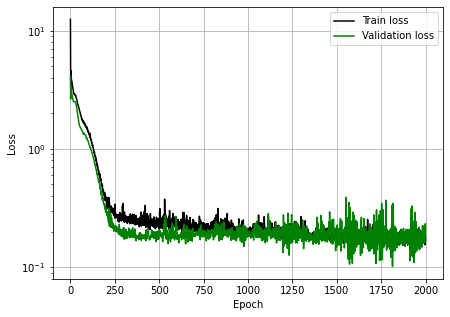

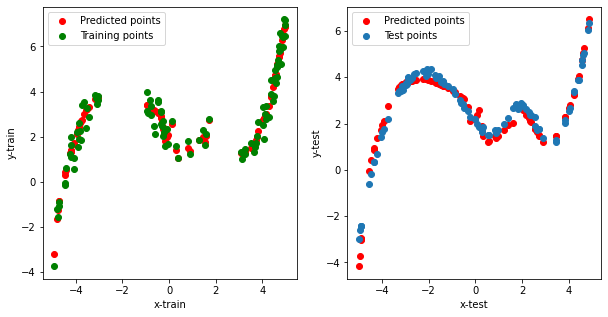

In [28]:
param ={'lr': 0.00724770262115946, 'momentum': 0.9085538147967525, 'optimizer': 'RAdam', 'p': 0.0013687406518706029, 'Nh1': 108.0, 'Nh2': 64.0}
Activation = F.relu
net = Net(Ni=1,Nh1=int(param['Nh1']),Nh2=int(param['Nh2']),No=1,p=param["p"],activation=Activation)
if param['optimizer'] =='SGD':
    optimizer = optim.SGD(net.parameters(), lr = param['lr'], momentum = param['momentum'])
else:
    optimizer = getattr(optim, param['optimizer'])(net.parameters(),lr= param['lr'])
validation_loss = []
loss_function = nn.MSELoss()
epochs = 2000
train_los = []
val_loss1 = []
finalLoss = []
torch.manual_seed(42)
for i in range(epochs):
    train_los.append(train(net,X_train,Y_train,optimizer).detach().numpy())
    val_loss1.append(test_loss(net,X_test,Y_test))
net.eval()
with torch.no_grad(): # Disable gradient tracking
    out1 = net(x.view(x.shape[0],1))
    yt_p1 = net(x_test.view(x_test.shape[0],1))
    loss = loss_function(yt_p1, y_test.view(y_test.shape[0],1))
    finalLoss.append(loss.detach().numpy())
print(f"training loss : {np.mean(train_los)}")
print(f"validation loss : {np.mean(val_loss1)}")
print(f"final test loss : {finalLoss}")

plt.figure(figsize=(7,5))
plt.semilogy(train_los, label='Train loss',c='k')
plt.semilogy(val_loss1, label='Validation loss',c='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()
Plot(out1.detach().numpy(),yt_p1.detach().numpy(),10,5)


### Optimizing without early stopping 

In [ ]:
def obj(trial):
    trainLoss = []
    kf = KFold(n_splits = 8, random_state = None)
    cfg = { 
          'device' : "cuda" if torch.cuda.is_available() else "cpu",
          'n_epochs' : 1500,
          'lr' : trial.suggest_loguniform('lr', 0.0007, 2e-2),#learning rate
          'momentum': trial.suggest_uniform('momentum', 0.85, 0.98),
          'optimizer': trial.suggest_categorical('optimizer',["Adam","RAdam","SGD"]),
          'activation': "relu",
          'p':trial.suggest_uniform('p', 0, 0.1),
          'Nh1':trial.suggest_discrete_uniform('Nh1', 16, 132, 4), 
          'Nh2':trial.suggest_discrete_uniform('Nh2', 16, 132, 4), 
          'Ni':1,
          'No':1
          }
    Activation = getattr(F, cfg['activation'])
    model = Net(Ni= cfg['Ni'],Nh1= int(cfg['Nh1']),Nh2 = int(cfg['Nh2']),No = cfg['No'],activation=Activation)
    if cfg['optimizer']=="SGD":
        optimizer = getattr(optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'],momentum = cfg['momentum'])
    else:
        optimizer = getattr(optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'])
    validation_loss = []
    val_loss = []
    tr_loss = []
    for train_index , test_index in kf.split(x):
        model.train() 
        xk = x[train_index]
        yk = y[train_index]
        xk_val = x[test_index]
        yk_val = y[test_index]
        model.apply(reset_weights)#for each fold the weights of network should be reset
        for i in range(cfg['n_epochs']):
            train(model,xk,yk,optimizer)
        loss = test_loss(model,xk_val,yk_val)
        validation_loss.append(loss)
    meanLoss = np.mean(validation_loss)
    return meanLoss

In [ ]:
studyNoEarly = optuna.create_study(sampler=optuna.samplers.TPESampler(),direction="minimize")
studyNoEarly.optimize(obj, n_trials=300, timeout=6000)

[I 2022-03-09 23:32:56,034] A new study created in memory with name: no-name-367c3428-595d-4837-b761-561ce7cfc130
[I 2022-03-09 23:33:06,553] Trial 0 finished with value: 0.31926894187927246 and parameters: {'lr': 0.011392200712191308, 'momentum': 0.9522626162831289, 'optimizer': 'RAdam', 'p': 0.09633246215699624, 'Nh1': 16.0, 'Nh2': 88.0}. Best is trial 0 with value: 0.31926894187927246.
[I 2022-03-09 23:33:17,164] Trial 1 finished with value: 0.3913803696632385 and parameters: {'lr': 0.0010573091399750446, 'momentum': 0.947301296985097, 'optimizer': 'RAdam', 'p': 0.05337338782851282, 'Nh1': 80.0, 'Nh2': 20.0}. Best is trial 0 with value: 0.31926894187927246.
[I 2022-03-09 23:33:23,922] Trial 2 finished with value: 0.3354841470718384 and parameters: {'lr': 0.0014287628779474188, 'momentum': 0.8661959938659453, 'optimizer': 'SGD', 'p': 0.0771239762569665, 'Nh1': 60.0, 'Nh2': 48.0}. Best is trial 0 with value: 0.31926894187927246.
[I 2022-03-09 23:33:35,738] Trial 3 finished with value:

training loss : 0.4148682951927185
validation loss : 0.2854588031768799
final test loss : [array(0.15990153, dtype=float32)]


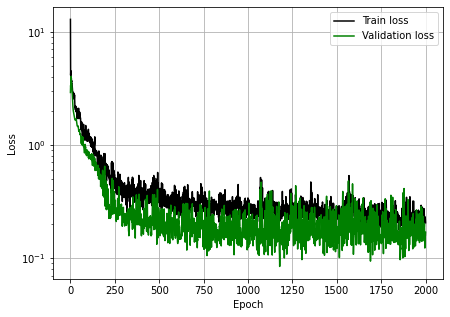

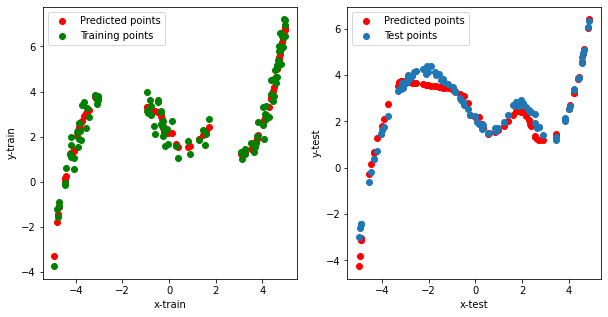

In [ ]:
param = {'lr': 0.01849318422853055, 'momentum': 0.8565381172214622, 'optimizer': 'RAdam', 'p': 0.055591738894736654, 'Nh1': 124.0, 'Nh2': 80.0}
Activation = F.relu
net = Net(Ni=1, Nh1=int(param['Nh1']), Nh2=int(param['Nh2']), No=1, p=param["p"], activation = Activation)
if param['optimizer'] =='SGD':
    optimizer = optim.SGD(net.parameters(), lr = param['lr'], momentum = param['momentum'])
else:
    optimizer = getattr(optim, param['optimizer'])(net.parameters(),lr= param['lr'])
validation_loss = []
loss_function = nn.MSELoss()
epochs = 2000
train_los = []
val_loss1 = []
finalLoss = []
torch.manual_seed(42)
for i in range(epochs):
    train_los.append(train(net,X_train,Y_train,optimizer).detach().numpy())
    val_loss1.append(test_loss(net,X_test,Y_test))
net.eval()
with torch.no_grad(): # Disable gradient tracking
    out2 = net(x.view(x.shape[0],1))
    yt_p2 = net(x_test.view(x_test.shape[0],1))
    loss = loss_function(yt_p2, y_test.view(y_test.shape[0],1))
    finalLoss.append(loss.detach().numpy())
print(f"training loss : {np.mean(train_los)}")
print(f"validation loss : {np.mean(val_loss1)}")
print(f"final test loss : {finalLoss}")

plt.figure(figsize=(7,5))
plt.semilogy(train_los, label='Train loss',c='k')
plt.semilogy(val_loss1, label='Validation loss',c='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()
Plot(out2.detach().numpy(),yt_p2.detach().numpy(),10,5)


## Optimizing Network with one hidden layers

### optimization while using early stopping  

In [ ]:
def obj(trial):
    kf = KFold(n_splits = 5, random_state = None)
    cfg = { 
          'n_epochs' : 1000,
          'lr' : trial.suggest_loguniform('lr', 0.0001, 1e-2),
          'momentum': trial.suggest_uniform('momentum', 0.85, 0.98),
          'optimizer': trial.suggest_categorical('optimizer',["SGD", "RAdam","Adam"]),
          'activation': "relu",
          'p':trial.suggest_uniform('p', 0, 0.1),
          'Nh1':trial.suggest_discrete_uniform('Nh1', 16, 128, 4), 
          'Ni':1,'No':1
          }
    Activation = getattr(F, cfg['activation'])
    model = Net_one_layer(Ni= cfg['Ni'],Nh= int(cfg['Nh1']),No = cfg['No'],activation=Activation)
    if cfg['optimizer']=="SGD":
        optimizer = getattr(optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'],momentum = cfg['momentum'])
    else:
        optimizer = getattr(optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'])
    validation_loss = []
    val_loss = []
    tr_loss = []
    for train_index , test_index in kf.split(x):
        model.train()
        xk = x[train_index]
        yk = y[train_index]
        xk_val = x[test_index]
        yk_val = y[test_index]
        early_stopping = EarlyStopping()
        model.apply(reset_weights)#for each fold the weights of network should be reset
        for i in range(cfg['n_epochs']):
            train(model,xk,yk,optimizer)
            loss = test_loss(model,xk_val,yk_val)
            early_stopping(loss)
            if early_stopping.early_stop:
                break
        loss = test_loss(model,xk_val,yk_val)
        validation_loss.append(loss)
    meanLoss = np.mean(validation_loss)
    return meanLoss

In [ ]:
study1 = optuna.create_study(sampler=optuna.samplers.TPESampler(),direction="minimize")
study1.optimize(obj, n_trials=300, timeout=6000)

[I 2022-03-10 00:44:29,041] A new study created in memory with name: no-name-a47ee572-10b5-4e1e-b933-808f310a5b5b
[I 2022-03-10 00:44:31,293] Trial 0 finished with value: 2.2597920894622803 and parameters: {'lr': 0.002270550511923632, 'momentum': 0.9024317158880326, 'optimizer': 'RAdam', 'p': 0.032383298282848284, 'Nh1': 44.0}. Best is trial 0 with value: 2.2597920894622803.
[I 2022-03-10 00:44:34,384] Trial 1 finished with value: 0.9189494848251343 and parameters: {'lr': 0.0037969930624973044, 'momentum': 0.8950518300815649, 'optimizer': 'Adam', 'p': 0.06073447233856665, 'Nh1': 124.0}. Best is trial 1 with value: 0.9189494848251343.
[I 2022-03-10 00:44:36,549] Trial 2 finished with value: 2.1354451179504395 and parameters: {'lr': 0.0025106969926489, 'momentum': 0.9770775673236337, 'optimizer': 'RAdam', 'p': 0.08961865495756637, 'Nh1': 88.0}. Best is trial 1 with value: 0.9189494848251343.
[I 2022-03-10 00:44:38,527] Trial 3 finished with value: 2.4335122108459473 and parameters: {'lr'

In [44]:
from matplotlib import test
param =  {'lr': 0.00988260947759074, 'momentum': 0.9685252148345241, 'optimizer': 'Adam', 'p': 0.07545406151668362, 'Nh1': 40.0}
Activation = F.relu
net = Net_one_layer(Ni=1, Nh=int(param['Nh1']),No=1, p=param["p"], activation = Activation)
if param['optimizer'] =='SGD':
    optimizer = optim.SGD(net.parameters(), lr = param['lr'], momentum = param['momentum'])
else:
    optimizer = getattr(optim, param['optimizer'])(net.parameters(),lr= param['lr'])
validation_loss = []
loss_function = nn.MSELoss()
epochs = 2000
train_los = []
val_loss1 = []
finalLoss = []
torch.manual_seed(42)
for i in range(epochs):
    train_los.append(train(net,X_train,Y_train,optimizer).detach().numpy())
    val_loss1.append(test_loss(net,X_test,Y_test))
net.eval()
with torch.no_grad(): # Disable gradient tracking
    out3 = net(x.view(x.shape[0],1))
    yt_p1 = net(x_test.view(x_test.shape[0],1))
    loss = loss_function(yt_p1, y_test.view(y_test.shape[0],1))
    finalLoss.append(loss.detach().numpy())
print(f"training loss : {np.mean(train_los)}")
print(f"validation loss : {np.mean(val_loss1)}")
print(f"final loss : {finalLoss}")

training loss : 0.6496952176094055
validation loss : 0.3927041292190552
final loss : [array(0.3223431, dtype=float32)]


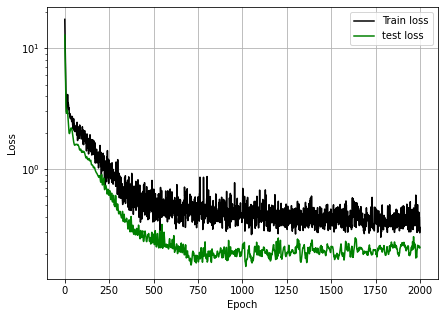

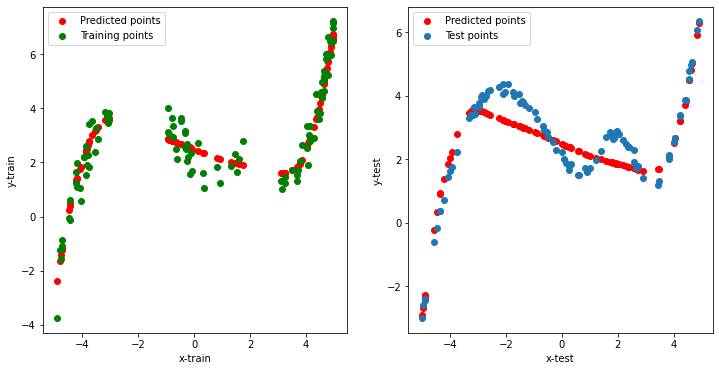

In [45]:
plt.figure(figsize=(7,5))
plt.semilogy(train_los, label='Train loss',c='k')
plt.semilogy(val_loss1, label='test loss',c='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()
Plot(out3.detach().numpy(),yt_p1.detach().numpy(),12,6)

### optimizing network with one hidden layer without using Early stopping

In [ ]:
def obj(trial):
    kf = KFold(n_splits = 8, random_state = None)
    cfg = { 
          'n_epochs' : 1000,
          'lr' : trial.suggest_loguniform('lr', 0.0001, 1e-2),
          'momentum': trial.suggest_uniform('momentum', 0.85, 0.98),
          'optimizer': trial.suggest_categorical('optimizer',["SGD", "RAdam","Adam"]),
          'activation': "relu",
          'p':trial.suggest_uniform('p', 0, 0.1),
          'Nh1':trial.suggest_discrete_uniform('Nh1', 16, 128, 4), 
          'Ni':1,'No':1
          }
    
    Activation = getattr(F, cfg['activation'])
    model = Net_one_layer(Ni= cfg['Ni'],Nh= int(cfg['Nh1']),No = cfg['No'],activation=Activation)
    if cfg['optimizer']=="SGD":
        optimizer = getattr(optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'],momentum = cfg['momentum'])
    else:
        optimizer = getattr(optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'])
    validation_loss = []
    val_loss = []
    tr_loss = []
    for train_index , test_index in kf.split(x):
        model.train()
        xk = x[train_index]
        yk = y[train_index]
        xk_val = x[test_index]
        yk_val = y[test_index]
        model.apply(reset_weights)#for each fold the weights of network should be reset
        for i in range(cfg['n_epochs']):
            train(model,xk,yk,optimizer)
        loss = test_loss(model,xk_val,yk_val)
        validation_loss.append(loss)
    meanLoss = np.mean(validation_loss)
    return meanLoss

In [ ]:
study1 = optuna.create_study(sampler=optuna.samplers.TPESampler(),direction="minimize")
study1.optimize(obj, n_trials=300, timeout=6000)

[I 2022-03-10 01:42:13,012] A new study created in memory with name: no-name-4ac58e8a-66d1-411b-ab49-292c091a5438
[I 2022-03-10 01:42:17,421] Trial 0 finished with value: 0.865955114364624 and parameters: {'lr': 0.0024587809819161277, 'momentum': 0.8587862387113491, 'optimizer': 'SGD', 'p': 0.09379264292950985, 'Nh1': 120.0}. Best is trial 0 with value: 0.865955114364624.
[I 2022-03-10 01:42:22,535] Trial 1 finished with value: 0.3844151496887207 and parameters: {'lr': 0.004248230225985847, 'momentum': 0.890449802689394, 'optimizer': 'Adam', 'p': 0.020762786969004923, 'Nh1': 48.0}. Best is trial 1 with value: 0.3844151496887207.
[I 2022-03-10 01:42:28,544] Trial 2 finished with value: 0.3332136869430542 and parameters: {'lr': 0.006657685777597948, 'momentum': 0.9299648953267139, 'optimizer': 'RAdam', 'p': 0.07171238495213443, 'Nh1': 36.0}. Best is trial 2 with value: 0.3332136869430542.
[I 2022-03-10 01:42:33,592] Trial 3 finished with value: 0.7537165284156799 and parameters: {'lr': 0

training loss : 0.6834082007408142
validation loss : 0.47704246640205383
final loss : [array(0.3223431, dtype=float32)]


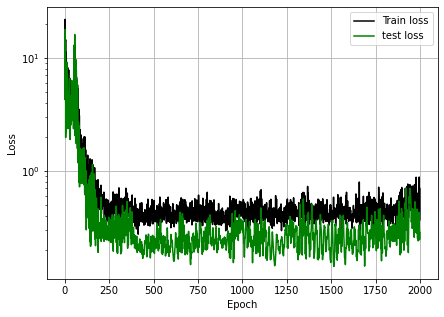

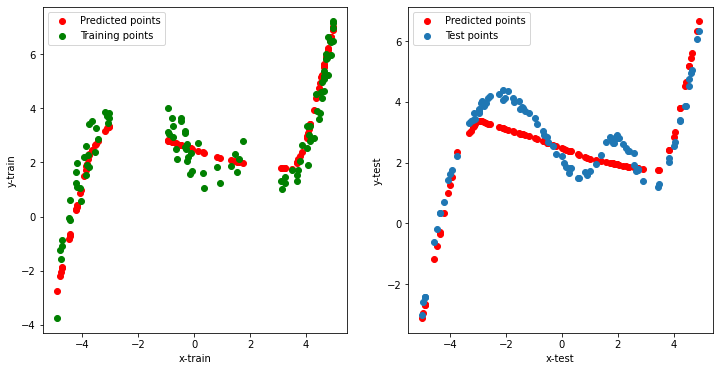

In [46]:
from matplotlib import test
param = {'lr': 0.008449914584052217, 'momentum': 0.9796193517645922, 'optimizer': 'SGD', 'p': 0.07170957716815626, 'Nh1': 76.0}
Activation = F.relu
net = Net_one_layer(Ni=1, Nh=int(param['Nh1']),No=1, p=param["p"], activation = Activation)
if param['optimizer'] =='SGD':
    optimizer = optim.SGD(net.parameters(), lr = param['lr'], momentum = param['momentum'])
else:
    optimizer = getattr(optim, param['optimizer'])(net.parameters(),lr= param['lr'])
validation_loss = []
loss_function = nn.MSELoss()
epochs = 2000
train_los = []
val_loss1 = []
finalLoss = []
torch.manual_seed(42)
for i in range(epochs):
    train_los.append(train(net,X_train,Y_train,optimizer).detach().numpy())
    val_loss1.append(test_loss(net,X_test,Y_test))
net.eval()
with torch.no_grad(): # Disable gradient tracking
    out4 = net(x.view(x.shape[0],1))
    yt_p4 = net(x_test.view(x_test.shape[0],1))
    loss = loss_function(yt_p1, y_test.view(y_test.shape[0],1))
    finalLoss.append(loss.detach().numpy())
print(f"training loss : {np.mean(train_los)}")
print(f"validation loss : {np.mean(val_loss1)}")
print(f"final loss : {finalLoss}")

plt.figure(figsize=(7,5))
plt.semilogy(train_los, label='Train loss',c='k')
plt.semilogy(val_loss1, label='test loss',c='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()
Plot(out4.detach().numpy(),yt_p4.detach().numpy(),12,6)

# output of network with best **hyperparameters** found in above parts, and visualization the prediction

------------------------------------------------
final test loss : [array(0.10237639, dtype=float32)]
------------------------------------------------


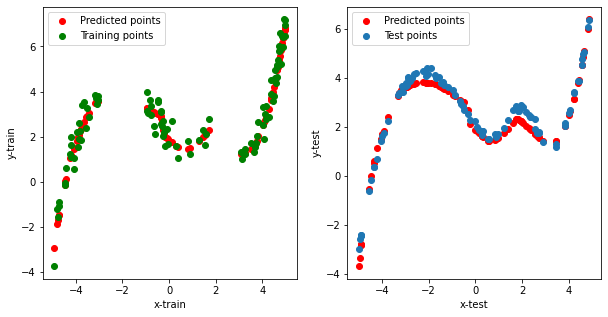

In [60]:
param ={'lr': 0.00724770262115946, 'momentum': 0.9085538147967525, 'optimizer': 'RAdam', 'p': 0.0013687406518706029, 'Nh1': 108.0, 'Nh2': 64.0}
Activation = F.relu
net = Net(Ni=1,Nh1=int(param['Nh1']),Nh2=int(param['Nh2']),No=1,p=param["p"],activation=Activation)
if param['optimizer'] =='SGD':
    optimizer = optim.SGD(net.parameters(), lr = param['lr'], momentum = param['momentum'])
else:
    optimizer = getattr(optim, param['optimizer'])(net.parameters(),lr= param['lr'])
loss_function = nn.MSELoss()
epochs = 2000
finalLoss = []
torch.manual_seed(42)
for i in range(epochs):
    train(net,x,y,optimizer).detach().numpy()
net.eval()
with torch.no_grad(): # Disable gradient tracking
    out1 = net(x.view(x.shape[0],1))
    yt_p1 = net(x_test.view(x_test.shape[0],1))
    loss = loss_function(yt_p1, y_test.view(y_test.shape[0],1))
    finalLoss.append(loss.detach().numpy())
print("------------------------------------------------")
print(f"final test loss : {finalLoss}")
print("------------------------------------------------")
Plot(out1.detach().numpy(),yt_p1.detach().numpy(),10,5)


# Initialization of weights
In this section, we initialized the weights of network selected as final one with **xavier_normal_ distribution** and then trained it to see the effect of weight initialization.

training loss : 0.3403724133968353
validation loss : 0.28841713070869446
final test loss : [array(0.18151449, dtype=float32)]


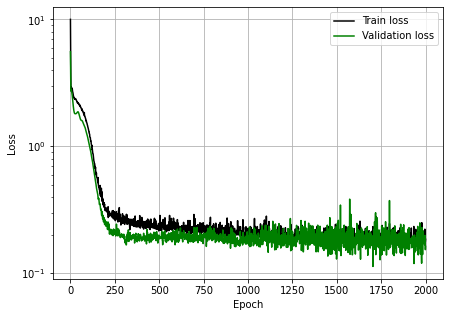

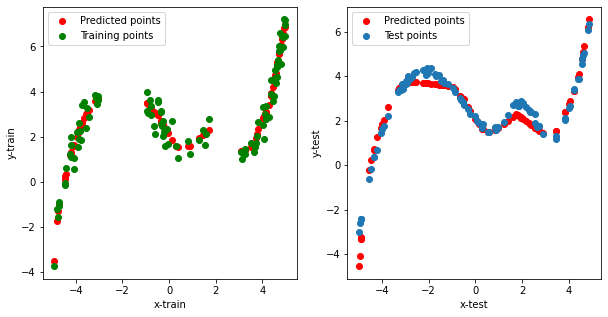

In [27]:
param ={'lr': 0.00724770262115946, 'momentum': 0.9085538147967525, 'optimizer': 'RAdam', 'p': 0.0013687406518706029, 'Nh1': 108.0, 'Nh2': 64.0}
param['activation']= 'relu'
param['activation']= getattr(F,param['activation'])
# activation = F.relu
netI = Net(Ni=1,Nh1=int(param['Nh1']),Nh2=int(param['Nh2']),No=1,p=param["p"],activation=param['activation'],initialization=True)
if param['optimizer'] =='SGD':
    optimizer = optim.SGD(netI.parameters(), lr = param['lr'], momentum = param['momentum'])
else:
    optimizer = getattr(optim, param['optimizer'])(netI.parameters(),lr= param['lr'])
validation_loss = []
loss_function = nn.MSELoss()
epochs = 2000
train_los = []
val_loss1 = []
finalLoss = []
torch.manual_seed(42)
for i in range(epochs):
    train_los.append(train(netI,X_train,Y_train,optimizer).detach().numpy())
    val_loss1.append(test_loss(netI,X_test,Y_test))
netI.eval()
with torch.no_grad(): # Disable gradient tracking
    out1 = netI(x.view(x.shape[0],1))
    yt_p1 = netI(x_test.view(x_test.shape[0],1))
    loss = loss_function(yt_p1, y_test.view(y_test.shape[0],1))
    finalLoss.append(loss.detach().numpy())
print(f"training loss : {np.mean(train_los)}")
print(f"validation loss : {np.mean(val_loss1)}")
print(f"final test loss : {finalLoss}")

plt.figure(figsize=(7,5))
plt.semilogy(train_los, label='Train loss',c='k')
plt.semilogy(val_loss1, label='Validation loss',c='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()
Plot(out1.detach().numpy(),yt_p1.detach().numpy(),10,5)


# visualization of activations

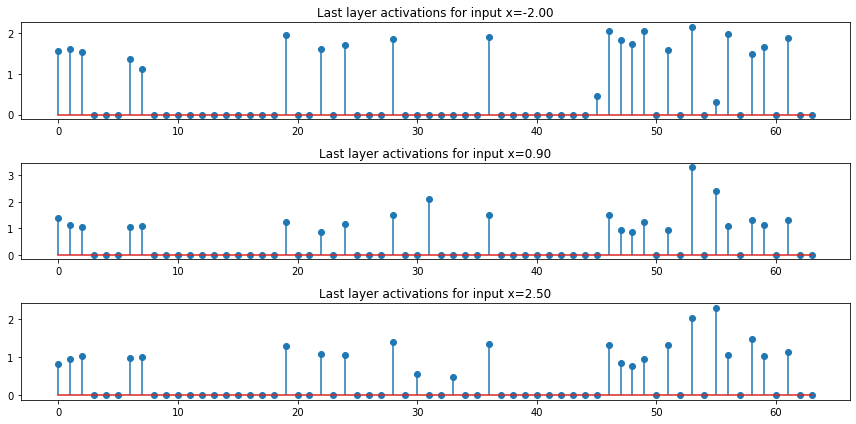

In [63]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)
### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)
device = "cuda" if torch.cuda.is_available() else "cpu"
### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([-2]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation
### Remove hook
hook_handle.remove()
### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

## Weight histograms

Text(0.5, 1.0, 'weights of layer two')

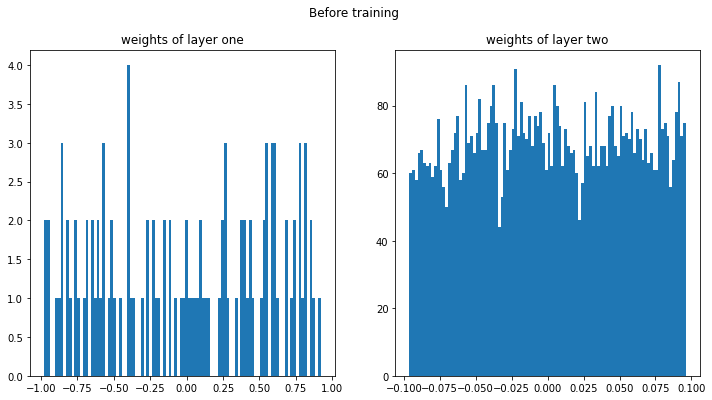

<Figure size 432x288 with 0 Axes>

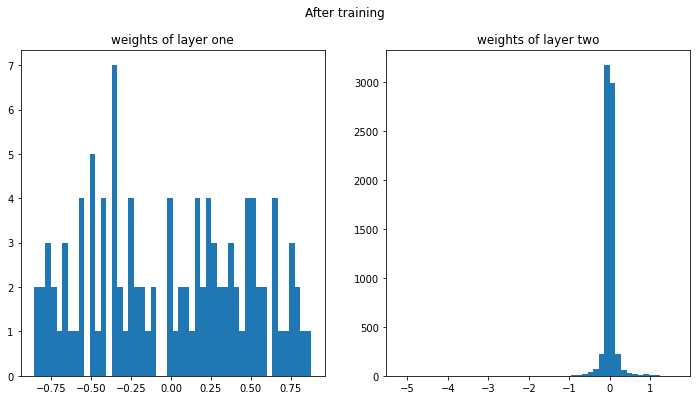

In [31]:
param ={'lr': 0.00724770262115946, 'momentum': 0.9085538147967525, 'optimizer': 'RAdam', 'p': 0.0013687406518706029, 'Nh1': 108.0, 'Nh2': 64.0}
Activation = F.relu
net1 = Net(Ni=1,Nh1=int(param['Nh1']),Nh2=int(param['Nh2']),No=1,p=param["p"],activation=Activation)

layer1 = net1.fc1.weight.detach().numpy()
layer2 = net1.fc2.weight.detach().numpy()
fig1, axs1 = plt.subplots(1,2)
fig1.suptitle('Before training')
# fig.suptitle('Vertically stacked subplots')
fig1.set_figwidth(12)
fig1.set_figheight(6)
axs1[0].hist(layer1.flatten(), 100)
axs1[0].set_title('weights of layer one')
axs1[1].hist(layer2.flatten(), 100)
axs1[1].set_title('weights of layer two')

plt.figure()
fig, axs = plt.subplots(1,2)
fig.suptitle('After training')
fig.set_figwidth(12)
fig.set_figheight(6)
l1 = net.fc1.weight.detach().numpy()
l2 = net.fc2.weight.detach().numpy()
axs[0].hist(l1.flatten(), 50)
axs[0].set_title('weights of layer one')
axs[1].hist(l2.flatten(), 50)
axs[1].set_title('weights of layer two')